<a href="https://colab.research.google.com/github/amrit-thapa-2044/ICIMOD_permafrost_training_2022/blob/main/permafrost_mapping_using_python_original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

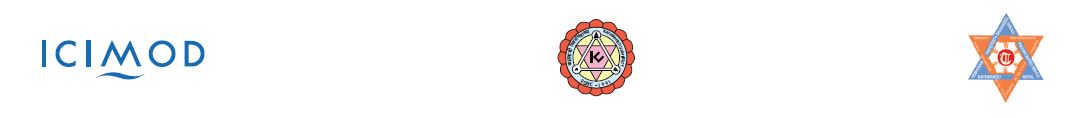

**<div align="center"><font size="4">REGIONAL TRAINING</font>**

<div align="center"><font size="4">Analysing permafrost in the Hindu Kush Himalaya using open access tools</font>

**<h1 align='center'>Permafrost probability mapping using logistic regression**

*This notebook is prepared for the participants of the regional training on **Analysing permafrost in the Hindu Kush Himalaya using open access tools** organized by ICIMOD through its Cryosphere Initiative under the Regional Programme on River Basins and Cryosphere in collaboration with Kathmandu university and Tribhuvan University.*

*The Cryosphere Initiative is supported by the Government of Norway and Swiss Agency for Development and Cooperation.*

Coded by: Prashant Baral & Amrit Thapa \
Email: pbaral@icimod.org & amrit.thapa@icimod.org
GitHub: https://github.com/amrit-thapa-2044/ICIMOD_permafrost_training_2022

---

***This exercise is conducted using the python coding language.***

# What is permafrost mapping?

Maps of permafrost extent and probability can be produced using a combination of mapped rock glaciers points, machine learning algorithms and other predictor variables. Mapped rock glacier points are classified as intact and relict indicating conditions for permafrost presence and absence respectively. Values of predictor variables extracted at mapped rock glacier points are used to train the machine learning algorithm. Mean annual air temperature (MAAT) and potential incoming solar radiation (PISR) are two commonly used predictor variables.

# Load required libraries


Initially, necessary libraries are imported. These libraries are used to read input files, analyze and visualize data and results. Images are read as *numpy* arrays. Training data, provided as a csv file, is read using *Pandas* library. *Matplotlib* library is used to make plots. *Contextily* is used to retrieve tile maps from the internet. *Scikit-learn* is the library for machine learning operations. *Gdal* library is used for working with geospatial data sets. *Rasterio* is a module used for operating raster data set. *Python Imaging Library (PIL)* is used to work with  different image formats. 

In [ ]:
# Importing the major libraries for  reading input files, analyzing and visualizing data and results

from google.colab import drive
from platform import python_version

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
!pip install contextily
import contextily as ctx

# Importing several functions from the scikit-learn library

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Importing libraries and functions for raster data processing

from osgeo import gdal

!pip install rasterio
import rasterio
from rasterio.plot import show

from PIL import Image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 65.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



We start this exercise by checking the version of Python available in Google Colab. Let's do this.


In [ ]:
# Printing the Python version available in Google Colab
print(python_version())

3.7.13


# Mount Google Drive


A pre-prepared training data set (.csv file) is used in this training. A folder named **ICIMOD_permafrost_training_2022** has already been shared with your Gmail ID.
Now, mount the Google Drive with Google Colab to import the required data. This will ask for gmail permission. You have to accept it before proceeding with the following steps.

In [ ]:
# Mounting the Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load training data

The next step is to read/load the prepared .csv file that consists of a dataset to train the logistic regression model. You have received a folder called ***ICIMOD_permafrost_training_2022***. Click on *Open* in your email, which will take you to the Google Drive. There click on the small arrow to the right of the folder name on top. A drop down will appear where you need to select 'Add Shortcut to Drive'. This will save the folder directly to your root folder. Only once that is done will the code below run.

Let's import the file and explore it. Can you identify the variables in the columns and remember them from the data preparation phase? What are the units we are looking at here? Also make sure that you understand why those specific locations have been chosen. What can we find at these locations? 

In [ ]:
# Importing the dataset to train the model
dataset = pd.read_csv('/content/drive/MyDrive/ICIMOD_permafrost_training_2022/input_permafrost/df_permafrost_uttarakhand_field_data_utm44n.csv')

# Get names of columns for visualization 
print(dataset.columns)

# Explore the first few rows of data 
dataset.head()

Index(['RGID', 'longitude', 'latitude', 'maat', 'pisr'], dtype='object')


,RGID,longitude,latitude,maat,pisr
0,1,445667.3452,3369434.664,-1.552178,1256.813477
1,1,401665.0128,3368026.277,-0.553961,1248.921509
2,1,433857.1046,3368747.286,-3.617237,1367.666138
3,1,307870.6123,3400898.924,-1.237953,1402.723022
4,1,264633.8469,3441171.615,-0.593433,1357.135986


Here, ***RGID*** indicates whether the mapped rock glacier is ***intact (1)*** or ***relict (0)***. ***longitude*** represents ***Easting or X coordinate*** and ***latitude*** represents ***Northing or Y coordinate*** of the mapped rock glacier points. ***maat*** is the value of ***mean annual air temperature (MAAT)*** and ***pisr*** is the value of ***potential incoming solar radiation (PISR)*** recorded at the mapped rock glacier points. 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# library for ggplot like figures
from plotnine import *

Let's look at the distribution of MAAT values recorded at points indicating intact (1) and relict (0) rock glaciers. We see that intact rock glaciers are located at areas with lower MAAT while relict ones are located at areas with higher MAAT.

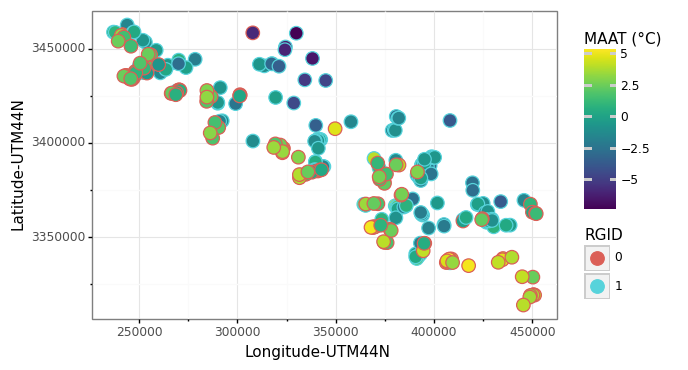

<ggplot: (8743743613461)>


In [ ]:
plot_lon_lat_MAAT=( ggplot(dataset)  # What data to use
    + geom_point(aes(x="longitude", y="latitude",fill='maat',color="factor(RGID)"),size=5)
    +ylab("Latitude-UTM44N")+xlab('Longitude-UTM44N')
    +labs(fill='MAAT (°C)')
    +labs(color='RGID')
    +theme_bw()
    +theme(figure_size=(6, 4)) #x,y)
)

print(plot_lon_lat_MAAT)

Let's now look at the distribution of PISR values recorded at points indicating intact and relict rock glaciers.

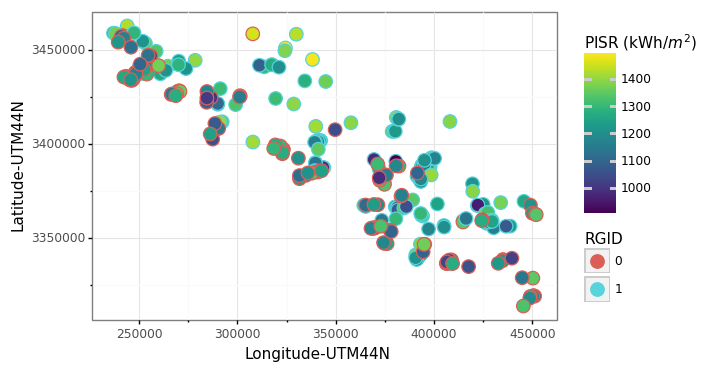

<ggplot: (8743743192901)>


In [ ]:
plot_lon_lat_PISR=( ggplot(dataset)  # What data to use
    + geom_point(aes(x="longitude", y="latitude",fill='pisr',color="factor(RGID)"),size=5)
    +ylab("Latitude-UTM44N")+xlab('Longitude-UTM44N')
    +labs(fill='PISR (kWh/$m^2$)')
    +labs(color='RGID')
    +theme_bw()
    +theme(figure_size=(6, 4)) #x,y)
)

print(plot_lon_lat_PISR)

We can now create boxplots to visualize the distribution of PISR values for intact (1) and relict (0) rock glaciers. Does this match with what you expect as a general value? Is there a reason why they could be not exactly the same?

 

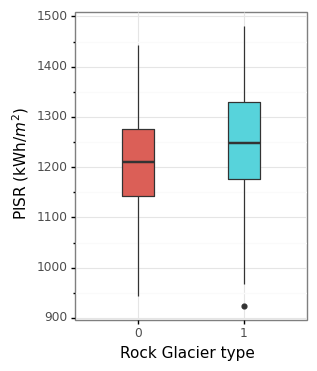

<ggplot: (8743741592093)>


In [ ]:
# Creating box plots to visualize the distribution of PISR values at points mapped as intact (1) and relict (0) rock glaciers
plot_PISR=( ggplot(dataset)  # What data to use
    + geom_boxplot(aes(x="factor(RGID)", y="pisr",fill='factor(RGID)'),width=0.3)
    +ylab("PISR (kWh/$m^2$)")+xlab('Rock Glacier type')
   +theme_bw()
   +theme(legend_position = "none")
   +theme(figure_size=(3, 4)) #x,y)
)

print(plot_PISR)


We can now do the same for our MAAT data. Is there a good explanation why for MAAT there is a distinct difference while for PISR that is much less clear between relict and intact rock glaciers?



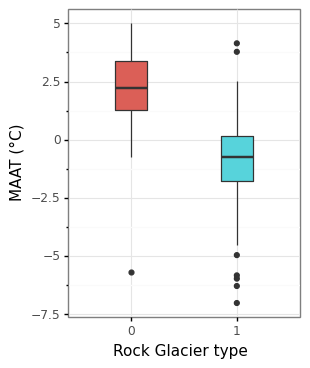

<ggplot: (8743743971021)>


In [ ]:
#Creating box plots to visualize the distribution of MAAT values at points mapped as intact (1) and relict (0) rock glaciers

plot_MAAT=( ggplot(dataset)  # What data to use
    + geom_boxplot(aes(x="factor(RGID)", y="maat",fill='factor(RGID)'),width=0.3)
    +ylab("MAAT (°C)")+xlab('Rock Glacier type')
    +theme_bw()
    +theme(legend_position = "none")
    +theme(figure_size=(3, 4)) #x,y)
)

print(plot_MAAT)



# Redefine training data

We need to arrange the training data in a specific format to train the logistic regression model. We define the predictor variables (MAAT and PISR) as variable 'X'. We define the  corresponding values denoting intact and relict rock glaciers as 'y'.

In [ ]:
X = dataset.iloc[:,[3,4]].values
y = dataset.iloc[:,0].values



Now we split the enitre data into four parts. The first part has 75% of the data and is used to train the logistic regression model. The second part has 25% of the data and is reserved for testing the accuracy of the trained model.

In [ ]:
# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)


# Visualize training and test data set (before data standardization)

Let's check the distribution of MAAT and PISR values in training and test data set using boxplots. We begin with PISR data in training data set.

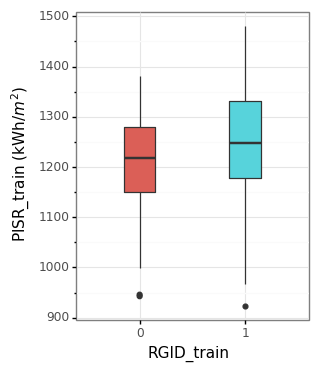

<ggplot: (8743741612465)>


In [ ]:
# convert numpy array to dataframe (x-training data)
df_train_PISR=pd.DataFrame(X_train[:, [1]])

# rename column
df_train_PISR.columns = ['PISR_train (kWh/$m^2$)']

# add a column and include RGID for training data
df_train_PISR['RGID_train'] = pd.DataFrame(y_train)
#print(df_train_PISR.head())

plot_train_PISR=( ggplot(df_train_PISR)  # What data to use
    + geom_boxplot(aes(x="factor(RGID_train)", y="PISR_train (kWh/$m^2$)",fill='factor(RGID_train)'),width=0.3)
    +theme_bw()
    +theme(legend_position = "none")
    +theme(figure_size=(3, 4)) #x,y)
    +xlab('RGID_train')
)

print(plot_train_PISR)

We see that the value of PISR in training data set ranges between 900 kWh/$m^2$ and 1500 kWh/$m^2$. Now, let's observe the values of PISR in test data set.

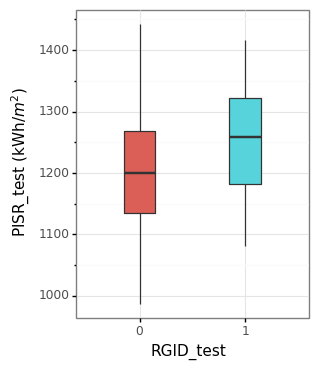

<ggplot: (8743741599521)>


In [ ]:
# convert numpy array to dataframe (x-training data)
df_test_PISR=pd.DataFrame(X_test[:, [1]])

# rename column
df_test_PISR.columns = ['PISR_test (kWh/$m^2$)']

# add a column and include RGID for training data
df_test_PISR['RGID_test'] = pd.DataFrame(y_test)

plot_test_PISR=( ggplot(df_test_PISR)  # What data to use
    + geom_boxplot(aes(x="factor(RGID_test)", y="PISR_test (kWh/$m^2$)",fill='factor(RGID_test)'),width=0.3)
    +theme_bw()
    +theme(legend_position = "none")
    +theme(figure_size=(3, 4)) #x,y)
    +xlab('RGID_test')
)

print(plot_test_PISR)

We see that the values of PISR in test data set range from about 950 kWh/$m^2$ up to 1450 kWh/$m^2$. Now, let's look at the values of MAAT in training data set.

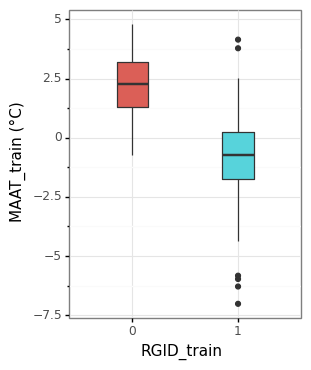

<ggplot: (8743738764509)>


In [ ]:
# convert numpy array to dataframe (x-training data)
df_train_MAAT=pd.DataFrame(X_train[:, [0]]) # indexing starts from 0 in python

# rename column
df_train_MAAT.columns = ['MAAT_train (°C)']

# add a column and include RGID for training data
df_train_MAAT['RGID_train'] = pd.DataFrame(y_train)
#print(df_train_PISR.head())

plot_train_MAAT=( ggplot(df_train_MAAT)  # What data to use
    + geom_boxplot(aes(x="factor(RGID_train)", y="MAAT_train (°C)",fill='factor(RGID_train)'),width=0.3)
    +theme_bw()
    +theme(legend_position = "none")
    +theme(figure_size=(3, 4)) #x,y)
    +xlab('RGID_train')
)

print(plot_train_MAAT)

We see that the value ranges between -7.5 °C and 5 °C. Let's now check the values of MAAT in the test data set. 

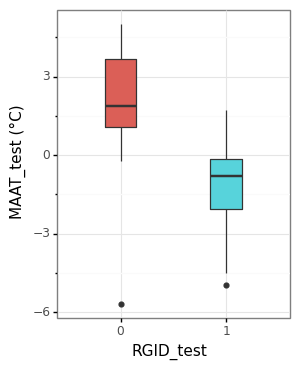

<ggplot: (8743738791341)>


In [ ]:
# convert numpy array to dataframe (x-training data)
df_test_MAAT=pd.DataFrame(X_test[:, [0]])

# rename column
df_test_MAAT.columns = ['MAAT_test (°C)']

# add a column and include RGID for training data
df_test_MAAT['RGID_test'] = pd.DataFrame(y_test)

plot_test_MAAT=( ggplot(df_test_MAAT)  # What data to use
    + geom_boxplot(aes(x="factor(RGID_test)", y="MAAT_test (°C)",fill='factor(RGID_test)'),width=0.3)
    +theme_bw()
    +theme(legend_position = "none")
    +theme(figure_size=(3, 4)) #x,y)
    +xlab('RGID_test')
)

print(plot_test_MAAT)

The values range between -6 °C and 6 °C. We can see that the numerical value of MAAT in training and test data set ranges from -7.5  to 6 and the numerical value of PISR in training and test data set ranges from 950 to 1500. Overall they are similar for training and test, which of course is crucial, as there shouldn;t be a distinct difference.

# Standardize training and test data set

Data standardization is an important data pre-processing step carried out before running many machine learning models. This step is performed to bring numerical values of all input variables to a common scale. 

In this permafrost mapping exercise, we use two predictor variables: MAAT and PISR. These variables have  values in varying magnitudes. Boxplot distribution for MAAT and PISR indicate that  MAAT ranges from -7 to +5 °C while PISR ranges from 900 to 1500 kWh/m<sup>2</sup>. Therefore, we perform a standardization of the data sets to standardize these variables so that the values remain in a fixed range. 

We apply the ***.fit_transform*** command in the ***StandardScaler*** function of the ***sklearn.preprocessing*** package, a package for data pre-processing, in the ***Scikit-learn*** library, to perform  standardization of training and test data set.
A value in a data set is standardized as :

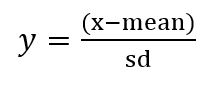

Here, ***x*** = a value in a training sample, ***mean*** = mean of the training sample, and ***sd*** = standard deviation of the training sample.


In [ ]:
# Standardize training and test data
sc_X = StandardScaler()
X_train_standardized = sc_X.fit_transform(X_train)
X_test_standardized = sc_X.transform(X_test)



# Visualize training and test data set (after data standardization)

Let's now look over the values of MAAT in the standardized training data  using a histogram plot.

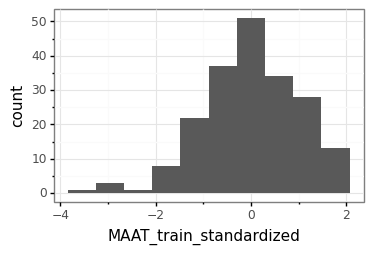

<ggplot: (8743738770121)>


In [ ]:
df_train_MAAT_standarized=pd.DataFrame(X_train_standardized[:, [0]])
df_train_MAAT_standarized.columns = ['MAAT_train_standardized']

plot_hist__train_MAAT_standarized=(ggplot(df_train_MAAT_standarized, aes(x='MAAT_train_standardized'))
 + geom_histogram(bins=10) # specify the number of bins
 +theme_bw()
 +theme(figure_size=(4, 2.5)) #x,y)
)

print(plot_hist__train_MAAT_standarized)

We see that the numerical values of standardized data of MAAT in training data now ranges between -4 and 2, values without a unit! Let's check the values of PISR in standardized training data.

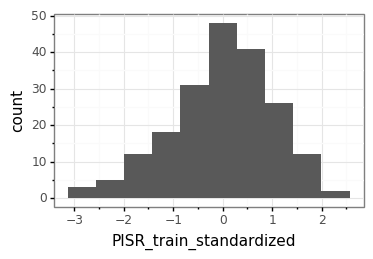

<ggplot: (8743738659733)>


In [ ]:
df_train_PISR_standarized=pd.DataFrame(X_train_standardized[:, [1]])
df_train_PISR_standarized.columns = ['PISR_train_standardized']

plot_hist__train_PISR_standarized=(ggplot(df_train_PISR_standarized, aes(x='PISR_train_standardized'))
 + geom_histogram(bins=10) # specify the number of bins
 +theme_bw()
 +theme(figure_size=(4, 2.5)) #x,y)
)

print(plot_hist__train_PISR_standarized)

We see that the numerical values of standardized data of PISR now ranges between -4 and 3. Let's now look at the values of MAAT in the standardized test data.

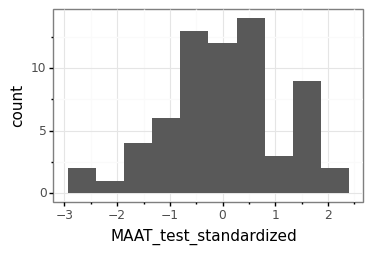

<ggplot: (8743738708289)>


In [ ]:
df_test_MAAT_standarized=pd.DataFrame(X_test_standardized[:, [0]])
df_test_MAAT_standarized.columns = ['MAAT_test_standardized']

plot_hist__test_MAAT_standarized=(ggplot(df_test_MAAT_standarized, aes(x='MAAT_test_standardized'))
 + geom_histogram(bins=10) # specify the number of bins
 +theme_bw()
 +theme(figure_size=(4, 2.5)) #x,y)
)

print(plot_hist__test_MAAT_standarized)

... and we do the same for PISR.

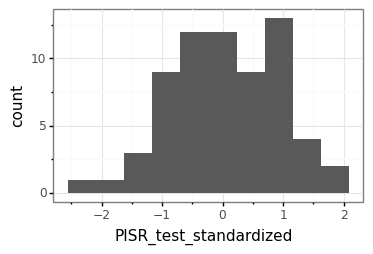

<ggplot: (8743743585573)>


In [ ]:
df_test_PISR_standarized=pd.DataFrame(X_test_standardized[:, [1]])
df_test_PISR_standarized.columns = ['PISR_test_standardized']

plot_hist__test_PISR_standarized=(ggplot(df_test_PISR_standarized, aes(x='PISR_test_standardized'))
 + geom_histogram(bins=10) # specify the number of bins
 +theme_bw()
 +theme(figure_size=(4, 2.5)) #x,y)
)

print(plot_hist__test_PISR_standarized)

We can see the data standardization procedure has now brought the values of MAAT and PISR in training and test data set to a comparable scale. Imagine if you would have datasets from other climate regions to also play with (where both absolute values of MAAT and PISR would of course be very different) you could now still compare all those data for the same purpose. This is what the word *standardization* finally means, irresepctive of external forcings, we bring it into a format that is useable for a machine to evaluate processes that may be the same across climates.

# Logistic regression model

Logistic regression is a machine learning algorithm which predicts the probability of occurrence of an event. It considers that the ***log-odds*** of that event occurring is dependent on the linear combination of one or more than one independent variable, referred to as the predictor variable.

***Log-odds*** can be considered as the abbreviation for ***natural logarithm of the odds ratio*** also called ***logit***. To understand log-odds, let's first understand what ***probability*** is and what ***odds/ odds ratio*** is. 

***Probability*** is the chance for an event to occur. For instance, when we say that the probability of a person winning an election ***(probability of success or odds of success)*** is 80%, we also mean that the chance of that person failing to win that election ***(probability of failure or odds of failure)*** is 20%.

***Odds ratio*** is defined as the ***ratio of probability of the success of an event to the probability of the failure*** of that same event. In the example above, ***odds ratio*** can be calculated as = 80%/20% = 4.

Now, ***log-odds*** of the above example can be calculated as the ***natural logarithm of the odds ratio*** or Ln(4) = 1.386.

Let's look at some equations.







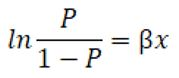


















This equation shows the natural logarithm of the odds ratio. Here, ***ln*** represents the natural logarithm, ***P*** indicates ***probability of success***, ***1-P*** indicates ***probability of failure***, ***x*** represents a predictor variable and ***β*** is the coefficient of the predictor variable ***x***. 

When we remove ***ln*** from the equation, we get the following equation:





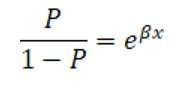




































Here, ***e*** represents the base of the natural logarithm, a mathematical constant approximately equal to 2.718281828459.

When we further solve the equation, we get the following equation:






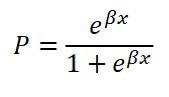






















Generally, there  is than one predictor variable and therefore, ***βx*** can be written as:








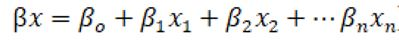




























Here, ***1,2,..,n*** represent ***n*** number of variables and ***β<sub>0</sub>*** represents the ***intercept***.

In this exercise, we use ***binary*** logistic regression model. This means that the model is expected to predict the target variable which is binary: 0 and 1. The model predicts the outcome based on two predictor variables: MAAT and PISR. There can be more than two predictor variables but in this exercise we only consider two commonly used predictor variables to estimate the probability of occurrence of permafrost.

Therefore, logistic Regression Model implemented in this exercise can be expressed using the following mathematical expression:
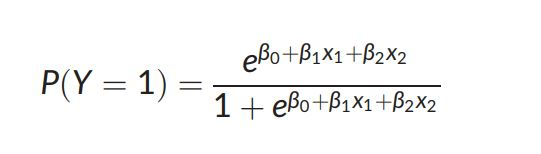


Here, ***P (Y = 1)***, represents the probability of output ***Y*** reaching the
value of 1. The terms ***β<sub>1</sub>*** and ***β<sub>2</sub>***  represent the coefficients of predictor variables ***x<sub>1</sub>*** and ***x<sub>2</sub>*** respectively, ***β<sub>0</sub>***  represents the intercept and ***e*** represents the base of the natural logarithm, approximately equal to 2.718281828459.

# Train the logistic regression model

For the binary logistic regression used in this exercise, points mapped along the initiation line of intact (1) and relict (0) rock glaciers were used. The initiation line refers to the line of origin of rock glaciers.

Then, two assumptions were made:
1. Points representing the initiation line location of intact rock glaciers indicate presence of permafrost and points representing the initiation line location of relict rock glaciers indicate absence of permafrost.

2. The existence of the two types of rock glaciers is dependent upon the MAAT and PISR values recorded at the points mapped along the initiation line of intact (1) and relict (0) rock glaciers.  

This means the binary outputs (1 and 0) would be dependent upon the values of MAAT and PISR and 1 would mean presence of permafrost while 0 would mean absence of permafrost.

The logistic regression classifier is now trained using mapped points for intact and relict rock glaciers and the corresponding values of MAAT and PISR recorded at these points. In other words, the classifier is trained using data set with known values of 1, 0, MAAT and PISR.


In [ ]:
# Fitting Logistic Regression to the Training Set

classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train_standardized, y_train)

LogisticRegression(random_state=0)

Once the classifier is trained, we can generate the coefficients of the two predictor variables MAAT and PISR as well as the intercept.

In [ ]:
# Printing the coefficients and the intercept of the Logistic Regression model

print(classifier.coef_, classifier.intercept_)

[[-2.96136869 -0.5785141 ]] [0.52073968]


Here, we print the coefficients and the intercept.

In [ ]:
# printing  β1, β2 and β0   
print("Coefficient of MAAT (β2) : %.8f, Coefficient of PISR (β1) : %.8f, Intercept (β0): %.8f" % (-2.96136869, -0.5785141, 0.52073968))
 

Coefficient of MAAT (β2) : -2.96136869, Coefficient of PISR (β1) : -0.57851410, Intercept (β0): 0.52073968


# Predict over the test data

Once the model is trained, we need to check the accuracy of the model. Therefore, we apply the trained model over the test data set or another data set where we have known values of 1, 0, MAAT and PISR. We provide the trained classifier with values of MAAT and PISR and  ask the model to predict the binary condition (1 and 0) for the provided data set of MAAT and PISR.

In [ ]:
# Predicting the Test set results
y_pred = classifier.predict(X_test_standardized)

# Evaluate the model

We assess the performance of the trained logistic regression model using a confusion matrix method. Here, the logistic regression model is being trained for binary classification—predicting one of two classes 0 (negative condition) and 1 (positive condition). A confusion matrix is a table that shows four potential outcomes of the logistic regression classifier: predicting 0 as 0 (true negative), predicting 0 as 1 (false positive), predicting 1 as 0 (false negative), and predicting 1 as 1 (true positive). In other words, a confusion matrix shows a comparision between what the class is based on the test data, and what the model predicted it to be.  We call a model prediction 'true negative' when it correctly did not predict where there was nothing to predict (e.g. prediction of no snowfall when there was no snowfall), 'false positive' when the model predicted something that didn't occur (e.g. occurence of COVID in a patient who has no COVID), 'false negative' is when we predict the lack of something while it is there (e.g. a dry river bed when actually water is flowing) and 'true positive' when we correctly predict a variable's occurence (e.g. prediction of rainfall when there was rainfall). Ideally a model should have a lot of hits in both 'true' categories and few in the 'false' categories. 


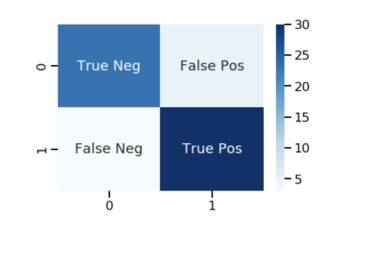

We can now go ahead and produce such a confusion matrix for the case of our model's output on predicting the occurence of intact and relict rock glaciers.

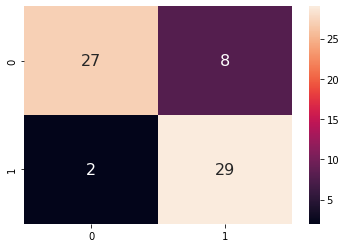

In [ ]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Visualizing the confusion matrix 
sns.heatmap(cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()


We see that the trained model correctly predicted 27 out of 35 relict rock glaciers (or condition for the absence of permafrost) and 29 out of 31 intact rock glaciers (or condition for the presence of permafrost). The model has higher accuracy in identifying conditions for the presence of permafrost compared to conditions for the absence of permafrost.

Now that we've trained and tested the model over the existing data we can use the trained logistic regression classifier over the predictor grids MAAT and PISR.

# Read grids for predictor variables

In this exercise, we are using two grids for predictor variables: MAAT and PISR. MAAT and PISR grids were produced and saved as *.tif* files in our previous exercise.

Before we can use data to run our model, we need to bring these grids into the right format. So far we have only worked with climate data for the specific locations of rock glaciers. But now we will need to work with climate data for the whole domain of our research area. This area you already know from the exercise on preparing input data. We start with reading in the rasters we produced (*.tif* files) with the ***Image.open*** command, open it as an array with ***np.array*** and then visualize the data with ***plt.imshow***. We then convert the array into a single column with the ***.ravel*** command.

An array is a variable which can contain more than one value. When we read a raster and open it as an array, it contains numbers stored in multiple rows and columns. In this exercise, we read temperature raster (MAAT grid) and solar radiation raster (PISR grid) as arrays. The temperature  raster, when opened as an array, consists of numbers in multiple rows and columns representing temperature values. Similarly, the solar radiation raster, when opened as an array, consists of numbers in multiple rows and columns representing solar radiation values. 

When we train our logistic regression classifier, we provide values for PISR and MAAT as numbers in two adjacent columns. When we apply our trained classifier over PISR and MAAT grids for the study area, we need to arrange these predictor variables exactly as they are arranged in our training data. Converting arrays into single columns is necessary to make this arrangement. 

We begin with  the solar radiation raster (PISR grid).

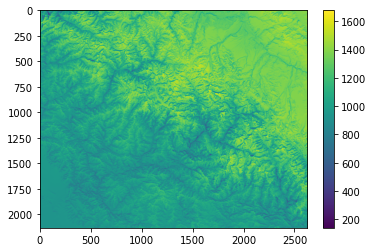

In [ ]:
#Reading .tif file for PISR and converting into an array
 
grid_pisr = Image.open('/content/drive/MyDrive/ICIMOD_permafrost_training_2022/input_permafrost/PISR_kwhr_90m_my_ext_actual_utm44n.tif')
array_pisr = np.array(grid_pisr)
plt.imshow(array_pisr)
plt.colorbar()
plt.show()
#Converting the array into a single column
b_pisr = array_pisr.ravel()

We can now do the same for our temperature raster (MAAT grid).

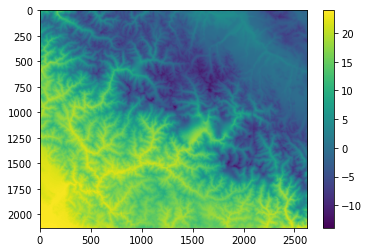

In [ ]:
#Reading .tif file for MAAT and converting into an array

grid_maat = Image.open('/content/drive/MyDrive/ICIMOD_permafrost_training_2022/input_permafrost/MAAT_degreeC_90m_downscaled_from_1000m_utm44n.tif')
array_maat = np.array(grid_maat)
plt.imshow(array_maat) 
plt.colorbar()
plt.show()

#Converting the array into a single column
b_maat = array_maat.ravel()

Since PISR and MAAT grids are of the same extent, single column arrays of PISR and MAAT are of the same length  and as we need both arrays as predictors, we now stack them with the ***.column_stack*** command to arrange them exactly as they are arranged in our training data and test data. 

After stacking, we need to apply ***.fit_transform*** command in ***StandardScaler*** function of ***sklearn.preprocessing*** package to perform  standardization of the data set of predictor variables.
We perform this data standardization because we have trained our logistic regression classifier using standardized training data set and this classifier only performs well if our data set of predictor variables is also standardized.

In [ ]:
#Stacking the two columns for MAAT and PISR
stack_grids = np.column_stack((b_maat,b_pisr))
sc_stack_grids = sc_X.fit_transform(stack_grids)

# Predict over the entire raster

Now, we predict permafrost probability using stacked and standardized columns of predictor variables and ***.predict*** command. This command uses the trained classifier and predicts permafrost presence or permafrost absence for each set of predictor variables. We obtain output as an array of inetegers 1 and 0 indicating permafrost presence and permafrost absence respectively.

In [ ]:
#Predicting the probability of permafrost (as 0 and 1) based on MAAT and PISR grids
y_pred_0_1 = classifier.predict(sc_stack_grids)

As we are interested in obtaining probability values between 0 and 1, we now predict permafrost probability using stacked and standardized columns of predictor variables and ***.predict_proba*** command. This command uses the trained classifier and predicts probability of permafrost presence as well as permafrost absence for each set of predictor variables. We obtain output as an array of real numbers between 0 and 1 in two columns. The first column indicates the probability of permafrost absence and the second column indicates the probability of permafrost presence. We separate the two columns into two separate arrays ***probability_no*** and ***probability_yes*** containing probability values for permafrost absence and permafrost presence respectively. 

In [ ]:
# Predicting the probability of permafrost (as values between 0 and 1) based on MAAT and PISR grids
y_pred_probability = classifier.predict_proba(sc_stack_grids)
probability_no = y_pred_probability[:,0]
probability_yes = y_pred_probability[:,1] 


Now, we use ***.reshape*** command to give the arrays **probability_no** and **probability_yes** the same shape as our predictor grids MAAT (**array_maat**) and PISR (**array_pisr**).

In [ ]:
# Reshaping the probability values for permafrost absence and permafrost presence
probability_no_reshape = np.reshape(probability_no,(2133,2620))
probability_yes_reshape = np.reshape(probability_yes,(2133,2620)) 

# Export permafrost probability distribution map

After having reshaped the arrays **probability_no** and  **probability_yes** into the same size as our arrays of predictor grids, we now want to store these reshaped arrays **probability_no_reshape** and **probability_yes_reshape** as ***.tif*** files for post processing in software like ArcMap or QGis or statistical analysis in standalone python or R scripts. We save the data to our Google Drive with the ***.save*** command.  

In [ ]:
# Convert to PIL Image and save
Image.fromarray(probability_no_reshape).save('/content/drive/MyDrive/ICIMOD_permafrost_training_2022/output_permafrost/Probability_permafrost_absence_georeference_no.tif')  
Image.fromarray(probability_yes_reshape).save('/content/drive/MyDrive/ICIMOD_permafrost_training_2022/output_permafrost/Probability_permafrost_presence_georeference_no.tif')                                              


However, the data we have produced so far is not georeferenced yet. That means it basically just exists as a matrix with associated column and row numbers but no coordinates. We can use our climate data, which is georeferenced, to do that now.

Before we visualize data, we convert it to an array again and then plot by first initializing the figure (***plt.figure***), then plotting the data (***plt.imshow***) and finally showing the plot (***plt.show***).

As you can see, there are no coordinates associated to the data. Colours indicate permafrost probability values, bright yellow areas indicate high probability for permafrost occurrence while dark blue areas indicate low probability for permafrost occurrence.

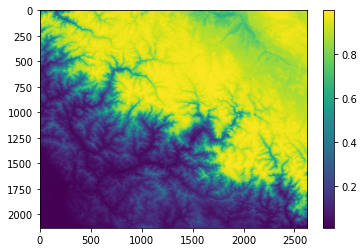

In [ ]:
# Importing georeferenced and non-georeferenced data set

ds = gdal.Open("/content/drive/MyDrive/ICIMOD_permafrost_training_2022/input_permafrost/MAAT_degreeC_90m_downscaled_from_1000m_utm44n.tif")
gt = ds.GetGeoTransform()
proj = ds.GetProjection()

im_permafrost_presence = Image.open('/content/drive/MyDrive/ICIMOD_permafrost_training_2022/output_permafrost/Probability_permafrost_presence_georeference_no.tif')
array_PP_yes = np.array(im_permafrost_presence)

plt.figure()
plt.imshow(array_PP_yes)
plt.colorbar()
plt.show()


The very last step is actually georeferencing the final permafrost probability grid. We get the projection via ***gt*** and ***proj*** from the climate data as retrieved in the previous step.

The data is then saved to your Drive via ***driver.Create*** from where you can subsequently download it and open it in post-processing software.

In [ ]:
# Georeferencing and exporting the permafrost probability distribution grid
driver = gdal.GetDriverByName("GTiff")
driver.Register()
outds = driver.Create("/content/drive/MyDrive/ICIMOD_permafrost_training_2022/output_permafrost/Probability_permafrost_presence_georeferenced_90m_utm44n.tif", xsize = array_PP_yes.shape[1],
                      ysize = array_PP_yes.shape[0], bands = 1, 
                      eType = gdal.GDT_Float32)
outds.SetGeoTransform(gt)
outds.SetProjection(proj)
outband = outds.GetRasterBand(1)
outband.WriteArray(array_PP_yes)
outband.SetNoDataValue(np.nan)
outband.FlushCache()

# Closing data set and bands

outband = None
outds = None

Assignments:

- Convert the georeferenced probability map to KML/KMZ using any GIS software and explore it in google earth.
- Discuss the map in a group of 3-4 participants. Where does the map show high probability and low probability of permafrost occurrence and why?

: <h1 align='center'>**THANK YOU**</h1>